# Code for Figs 7, S9, S10

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sb
from heapq import nlargest, nsmallest
from labellines import labelLines
from tqdm import tqdm

import xgi
from utils import (
    compute_eigenvalues_multi,
    node_swap,
    flag_complex_d2,
    degree_corr,
    deg_hetero_ratio,
)

sb.set_theme(style="ticks", context="paper")

fig_dir = "figures/"
results_dir = "results/"

Path(fig_dir).mkdir(parents=True, exist_ok=True)
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [2]:
data_folder = "data/"
data_files = os.listdir(data_folder)
data_files = [
    dat
    for dat in data_files
    if "xgi" not in dat and "Store" not in dat and not ".txt" in dat
]
data_files

['bn-macaque-rhesus_brain_1.edges',
 'bn-macaque-rhesus_cerebral-cortex_1.edges',
 'p.pacificus_neural.synaptic_1.graphml',
 'bn-cat-mixed-species_brain_1.edges',
 'c.elegans.herm_pharynx_1.graphml',
 'c.elegans_neural.male_1.graphml']

## Single dataset

In [3]:
# load data
i = 2

data_file = data_files[i]
net_name = ".".join(data_file.split(".")[:-1])
ext = data_file.split(".")[-1]

if ext == "edges":
    G = nx.read_edgelist(f"{data_folder}{data_file}")
elif ext == "graphml":
    G = nx.read_graphml(f"{data_folder}{data_file}")
    G = nx.Graph(G)
else:
    raise ValueError("Unknown data format")

print(net_name)
print(G)

largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)
print(G)

p.pacificus_neural.synaptic_1
Graph with 54 nodes and 141 edges
Graph with 54 nodes and 141 edges


In [4]:
S = flag_complex_d2(G, p2=None)  # build simplicial complex from the data

H = xgi.Hypergraph(S)  # convert to a hypergraph object so that we can shuffle edges
k1_dict = H.nodes.degree(order=1).asdict()

S._edge == H._edge  # check the edges are the same

True

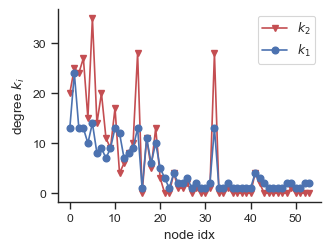

In [5]:
fig, ax = plt.subplots(figsize=(3.4, 2.5))

k1 = S.nodes.degree(order=1).asnumpy()
k2 = S.nodes.degree(order=2).asnumpy()

ax.plot(k2, "r-v", label="$k_2$")
ax.plot(k1, "b-o", label="$k_1$")

ax.set_xlabel("node idx")
ax.set_ylabel("degree $k_i$")

ax.legend()
sb.despine()

fig_name = f"degrees_swapped_{net_name}_0_swaps"

# plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

### Compute the swaps

In [6]:
n_swaps = [15, 30]  # number of node to select for swaps

iswap = n_swaps[0]

imaxs = nlargest(iswap, k1_dict, key=k1_dict.get)  # find nodes with largest k1 degree
print(imaxs)
imins = nsmallest(iswap, k1_dict, key=k1_dict.get)  # find nodes with lowest k1 degree
print(imins)

HH = H.copy()

for imin, imax in tqdm(zip(imins, imaxs)):

    HH = node_swap(HH, imin, imax, order=2)  # swap node memberships in 2-hypergedges

iswap = n_swaps[1]

imaxs = nlargest(iswap, k1_dict, key=k1_dict.get)
print(imaxs)
imins = nsmallest(iswap, k1_dict, key=k1_dict.get)
print(imins)

HHH = H.copy()

for imin, imax in tqdm(zip(imins, imaxs)):

    HHH = node_swap(HHH, imin, imax, order=2)  # swap node memberships in 2-hypergedges

['n1', 'n5', 'n0', 'n2', 'n3', 'n10', 'n15', 'n32', 'n11', 'n17', 'n4', 'n19', 'n7', 'n9', 'n14']
['n16', 'n22', 'n27', 'n29', 'n30', 'n33', 'n34', 'n36', 'n37', 'n38', 'n39', 'n40', 'n44', 'n45', 'n46']


15it [00:00, 425.82it/s]


['n1', 'n5', 'n0', 'n2', 'n3', 'n10', 'n15', 'n32', 'n11', 'n17', 'n4', 'n19', 'n7', 'n9', 'n14', 'n6', 'n13', 'n8', 'n12', 'n18', 'n20', 'n23', 'n41', 'n21', 'n26', 'n42', 'n24', 'n25', 'n28', 'n31']
['n16', 'n22', 'n27', 'n29', 'n30', 'n33', 'n34', 'n36', 'n37', 'n38', 'n39', 'n40', 'n44', 'n45', 'n46', 'n47', 'n50', 'n51', 'n24', 'n25', 'n28', 'n31', 'n35', 'n43', 'n48', 'n49', 'n52', 'n53', 'n21', 'n26']


30it [00:00, 449.86it/s]


In [7]:
xgi.num_edges_order(H, 1), xgi.num_edges_order(
    HH, 1
)  # check that the numbers are the same

(141, 141)

In [8]:
xgi.num_edges_order(H, 2), xgi.num_edges_order(
    HH, 2
)  # check that the numbers are the same

(117, 117)

In [9]:
assert H.edges.filterby("order", 1) == HH.edges.filterby("order", 1)

In [10]:
HHH.edges.filterby("order", 2).members() == HH.edges.filterby("order", 2).members()

False

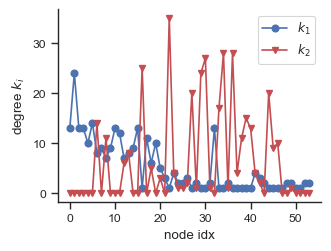

In [11]:
# plot degree sequences after swaps
fig, ax = plt.subplots(figsize=(3.4, 2.5))

k1s = HH.nodes.degree(order=1).asnumpy()
k2s = HH.nodes.degree(order=2).asnumpy()

ax.plot(k1s, "b-o", label="$k_1$")
ax.plot(k2s, "r-v", label="$k_2$")

ax.set_xlabel("node idx")
ax.set_ylabel("degree $k_i$")

ax.legend()
sb.despine()

fig_name = f"degrees_swapped_{net_name}_{n_swaps[0]}_swaps"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

# plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

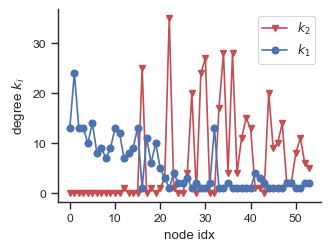

In [12]:
fig, ax = plt.subplots(figsize=(3.4, 2.5))

k1s = HHH.nodes.degree(order=1).asnumpy()
k2s = HHH.nodes.degree(order=2).asnumpy()

ax.plot(k2s, "r-v", label="$k_2$")
ax.plot(k1s, "b-o", label="$k_1$")

ax.set_xlabel("node idx")
ax.set_ylabel("degree $k_i$")

ax.legend()
sb.despine()

fig_name = f"degrees_swapped_{net_name}_{n_swaps[1]}_swaps"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

# plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [13]:
# check that degree correlation has decreased
degree_corr(H), degree_corr(HH), degree_corr(HHH)

(0.894537337540073, -0.44284407548758115, -0.5486495670245789)

In [14]:
# check that degree heterogeneity ratio is unchanged
deg_hetero_ratio(H), deg_hetero_ratio(HH), deg_hetero_ratio(HHH)

(1.2193900773782431, 1.2193900773782431, 1.2193900773782431)

In [15]:
alphas = np.arange(0, 1.01, 0.1)
n_alpha = len(alphas)
N = H.num_nodes

n_rep = 3

lyaps_HG = np.zeros((n_rep, len(alphas), N))
Ls = []

for ii, HGi in enumerate([H, HH, HHH]):

    for i, alpha in enumerate(alphas):
        lyap_multi = compute_eigenvalues_multi(
            HGi, orders=[1, 2], weights=[1 - alpha, alpha]
        )

        lyap_multi = np.sort(lyap_multi)[::-1]
        lyaps_HG[ii, i, :] = lyap_multi

    L = xgi.multiorder_laplacian(HGi, orders=[1, 2], weights=[1 - alpha, alpha])
    Ls.append(L)

## Single dataset Fig 7

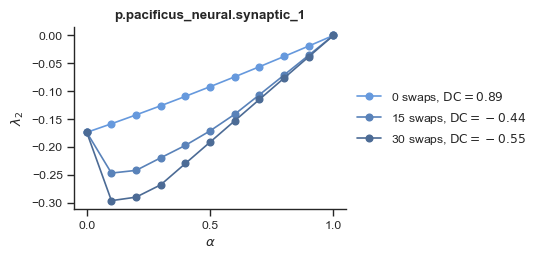

In [17]:
fig, ax = plt.subplots(figsize=(3.5, 2.36))

palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

jj = 5
ax.plot(
    alphas,
    lyaps_HG[0, :, jj],
    "o-",
    label=f"0 swaps, $\mathrm{{DC}}={degree_corr(H):.2f}$",
)
ax.plot(
    alphas,
    lyaps_HG[1, :, jj],
    "o-",
    label=f"{n_swaps[0]} swaps, $\mathrm{{DC}}={degree_corr(HH):.2f}$",
)
ax.plot(
    alphas,
    lyaps_HG[2, :, jj],
    "o-",
    label=f"{n_swaps[1]} swaps, $\mathrm{{DC}}={degree_corr(HHH):.2f}$",
)

ax.set_ylabel(r"$\lambda_2$")
ax.set_xlabel(r"$\alpha$")

# ax.set_yticks([-0.0, -0.5, -1])
ax.set_xticks([0, 0.5, 1])

ax.legend(loc="center left", frameon=False, bbox_to_anchor=(1, 0.5))
ax.set_title(f"{net_name}", weight="bold")

sb.despine()

fig_name = f"lambda-vs-heterogenity-{net_name}_swaps_{n_swaps}"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

# plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

In [18]:
np.savez(
    f"{results_dir}{net_name}_swaps_{n_swaps}",
    corr_H=degree_corr(H),
    corr_HH=degree_corr(HH),
    corr_HHH=degree_corr(HHH),
    lyaps_HG=lyaps_HG,
    alphas=alphas,
)

## All datasets - Fig S9

In [19]:
data_files

['bn-macaque-rhesus_brain_1.edges',
 'bn-macaque-rhesus_cerebral-cortex_1.edges',
 'p.pacificus_neural.synaptic_1.graphml',
 'bn-cat-mixed-species_brain_1.edges',
 'c.elegans.herm_pharynx_1.graphml',
 'c.elegans_neural.male_1.graphml']

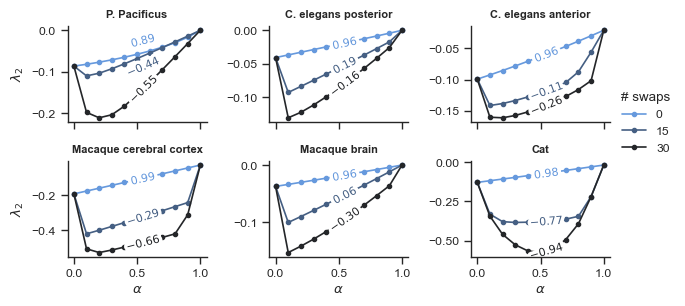

In [20]:
palette = sb.dark_palette("#69d", reverse=True, n_colors=3.5)
sb.set_palette(palette)
idx = [2, 5, 4, 1, 0, 3]

n_cols = 3

fig, axs = plt.subplots(2, n_cols, figsize=(7, 3), sharex=True, sharey=False)

for kk, data_file in enumerate(np.array(data_files)[idx]):

    try:

        ax = axs[kk // n_cols, kk % n_cols]

        net_name = ".".join(data_file.split(".")[:-1])

        if net_name == "bn-macaque-rhesus_brain_1":
            n_swaps = [15, 30]
            title = "Macaque brain"
        elif net_name == "bn-macaque-rhesus_cerebral-cortex_1":
            n_swaps = [15, 30]
            title = "Macaque cerebral cortex"
        elif net_name == "p.pacificus_neural.synaptic_1":
            n_swaps = [15, 30]
            title = "P. Pacificus"
        elif net_name == "bn-cat-mixed-species_brain_1":
            n_swaps = [15, 30]  # [5,15]
            title = "Cat"
        elif net_name == "c.elegans.herm_pharynx_1":
            n_swaps = [15, 30]
            title = "C. elegans anterior"
        elif net_name == "c.elegans_neural.male_1":
            n_swaps = [15, 30]
            title = "C. elegans posterior"

        data = np.load(f"{results_dir}{net_name}_swaps_{n_swaps}.npz")
        # print(net_name, "working")
        # print(kk // 4, kk % 4)

        corr_H = data["corr_H"]
        corr_HH = data["corr_HH"]
        corr_HHH = data["corr_HHH"]
        lyaps_HG = data["lyaps_HG"]
        alphas = data["alphas"]

        ax.plot(alphas, lyaps_HG[0, :, 1], "o-", label=f"${corr_H:.2f}$", ms=3)
        ax.plot(alphas, lyaps_HG[1, :, 1], "o-", label=f"${corr_HH:.2f}$", ms=3)
        ax.plot(alphas, lyaps_HG[2, :, 1], "o-", label=f"${corr_HHH:.2f}$", ms=3)

        if net_name == "p.pacificus_neural.synaptic_1":
            offsets = [0.03, -0.025, 0]
        else:
            offsets = 0

        xvals = [0.55] * 3
        labelLines(
            ax.get_lines(), align=True, xvals=xvals, yoffsets=offsets, fontsize="small"
        )

        ax.set_title(f"{title}", weight="bold", fontsize="small")

    except Exception as e:
        print(net_name, "not computed yet", e)
        pass

plt.subplots_adjust(wspace=0.45, hspace=0.4)

axs[0, 0].set_ylabel(r"$\lambda_2$")
axs[1, 0].set_ylabel(r"$\lambda_2$")

axs[1, 0].set_xlabel(r"$\alpha$")
axs[1, 1].set_xlabel(r"$\alpha$")
axs[1, -1].set_xlabel(r"$\alpha$")
axs[1, -1].set_xticks([0, 0.5, 1])

axs[0, -1].legend(
    ["0", "15", "30"],
    title="# swaps",
    loc="center left",
    bbox_to_anchor=(1, -0),
    frameon=False,
)

sb.despine()

fig_name = f"figure_S9_lambda-swaps_all_nets"  # lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

# plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

## Shuffle synthetic hypergraphs

In [50]:
N = 300
m = 40

G = nx.watts_strogatz_graph(n=N, k=m, p=0.15)
net_name = f"WS_N_{N}_m_{m}"

S = flag_complex_d2(G, p2=None)

H = xgi.Hypergraph(S)
k1_dict = H.nodes.degree(order=1).asdict()

In [52]:
n_swaps = [15, 30]  # number of nodes to select for the swaps

iswap = n_swaps[0]

imaxs = nlargest(iswap, k1_dict, key=k1_dict.get)  # find nodes with largets k1 degree
print(imaxs)
imins = nsmallest(iswap, k1_dict, key=k1_dict.get)  # find nodes with lowest k1 degree
print(imins)

HH = H.copy()

for imin, imax in tqdm(zip(imins, imaxs)):

    HH = node_swap(HH, imin, imax, order=2)

iswap = n_swaps[1]

imaxs = nlargest(iswap, k1_dict, key=k1_dict.get)
print(imaxs)
imins = nsmallest(iswap, k1_dict, key=k1_dict.get)
print(imins)

HHH = H.copy()

for imin, imax in tqdm(zip(imins, imaxs)):

    HHH = node_swap(HHH, imin, imax, order=2)

[41, 141, 148, 186, 102, 128, 175, 60, 118, 121, 243, 275, 276, 0, 7]
[29, 164, 51, 191, 4, 5, 90, 159, 244, 284, 18, 22, 28, 50, 127]


15it [00:10,  1.47it/s]


[41, 141, 148, 186, 102, 128, 175, 60, 118, 121, 243, 275, 276, 0, 7, 59, 62, 81, 84, 95, 96, 103, 117, 124, 131, 134, 153, 202, 224, 226]
[29, 164, 51, 191, 4, 5, 90, 159, 244, 284, 18, 22, 28, 50, 127, 144, 242, 272, 36, 43, 47, 101, 123, 132, 135, 157, 158, 165, 169, 193]


30it [00:20,  1.47it/s]


In [53]:
alphas = np.arange(0, 1.01, 0.1)
n_alpha = len(alphas)
N = H.num_nodes

n_rep = 3

lyaps_HG = np.zeros((n_rep, len(alphas), N))
Ls = []

for ii, HGi in enumerate(tqdm([H, HH, HHH])):

    for i, alpha in enumerate(alphas):
        lyap_multi = compute_eigenvalues_multi(
            HGi, orders=[1, 2], weights=[1 - alpha, alpha]
        )

        lyap_multi = np.sort(lyap_multi)[::-1]
        lyaps_HG[ii, i, :] = lyap_multi

    L = xgi.multiorder_laplacian(HGi, orders=[1, 2], weights=[1 - alpha, alpha])
    Ls.append(L)

100%|█████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.43s/it]


In [54]:
np.savez(
    f"{results_dir}{net_name}_swaps_{n_swaps}",
    corr_H=degree_corr(H),
    corr_HH=degree_corr(HH),
    corr_HHH=degree_corr(HHH),
    lyaps_HG=lyaps_HG,
    alphas=alphas,
)

### Fig S10 

In [68]:
data_files = [
    f"BA_N_{N}_m_{m}_swaps_{n_swaps}.npz",
    f"WS_N_{N}_m_{m}_swaps_{n_swaps}.npz",
]

titles = [f"BA, $m={m}$", f"WS, $m={m}$"]

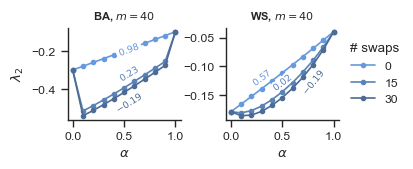

In [98]:
palette = sb.dark_palette("#69d", reverse=True)
sb.set_palette(palette)

fig, axs = plt.subplots(1, 2, figsize=(3.5, 1.2), sharey=False)

for kk, dat in enumerate(data_files):

    ax = axs[kk]
    data = np.load(f"{results_dir}{dat}")

    corr_H = data["corr_H"]
    corr_HH = data["corr_HH"]
    corr_HHH = data["corr_HHH"]
    lyaps_HG = data["lyaps_HG"]
    alphas = data["alphas"]

    ax.plot(alphas, lyaps_HG[0, :, 1], "o-", label=f"${corr_H:.2f}$", ms=3)
    ax.plot(alphas, lyaps_HG[1, :, 1], "o-", label=f"${corr_HH:.2f}$", ms=3)
    ax.plot(alphas, lyaps_HG[2, :, 1], "o-", label=f"${corr_HHH:.2f}$", ms=3)

    if kk == 0:
        yoffsets = [0, 0.06, -0.07]
        xvals = [0.55] * 3
        ow = 5
    elif kk == 1:
        yoffsets = [0.02, 0.017, -0.03]
        xvals = [0.3, 0.5, 0.8]
        ow = 3

    labelLines(
        ax.get_lines(),
        align=True,
        xvals=xvals,
        yoffsets=yoffsets,
        fontsize="x-small",
        outline_width=ow,
    )

    ax.set_title(f"{titles[kk]}", weight="bold", fontsize="small")

axs[0].set_ylabel(r"$\lambda_2$")


axs[0].set_xlabel(r"$\alpha$")
axs[1].set_xlabel(r"$\alpha$")

axs[1].legend(
    ["0", "15", "30"],
    title="# swaps",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
)
sb.despine()

plt.subplots_adjust(wspace=0.4)

fig_name = f"figure_S20_lambda-vs-heterogenity-BA-WS_swaps_{n_swaps}"

plt.savefig(f"{fig_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{fig_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")